# Generative Model (Raman beers dataset)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.8


In [2]:
# import local utility functions and classes
import sys
sys.path.append('../utils')
import models as mdl
import utils as utl
from data import Data

## Load raw data and plot

In [3]:
# init data object
data_obj = Data('../../data/beers/Raman_beers.csv', 'label', -1)
data = data_obj.data
data.head(5)

,1,2,3,4,5,6,7,8,9,10,...,3445,3446,3447,3448,3449,3450,3451,3452,3453,label
39,0.000332,0.000432,0.000606,0.000738,0.000647,0.000451,0.000611,0.000736,0.000773,0.000730,...,0.028614,0.028504,0.028416,0.028404,0.028483,0.028615,0.028731,0.028777,0.028760,1
25,0.000312,0.000452,0.000572,0.000695,0.000833,0.000920,0.000875,0.000690,0.000454,0.000274,...,0.030312,0.030401,0.030427,0.030355,0.030220,0.030109,0.030088,0.030146,0.030218,2
26,0.000634,0.000661,0.000715,0.000770,0.000723,0.000527,0.000519,0.000715,0.000809,0.000798,...,0.018492,0.018507,0.018457,0.018357,0.018258,0.018202,0.018183,0.018167,0.018138,1
43,0.000396,0.000281,0.000322,0.000473,0.000504,0.000451,0.000503,0.000509,0.000515,0.000531,...,0.029342,0.029342,0.029371,0.029443,0.029530,0.029581,0.029579,0.029559,0.029557,1
35,0.000265,0.000224,0.000201,0.000230,0.000406,0.000599,0.000654,0.000547,0.000395,0.000335,...,0.019307,0.019316,0.019314,0.019321,0.019332,0.019328,0.019316,0.019315,0.019327,1


1: blue
2: red


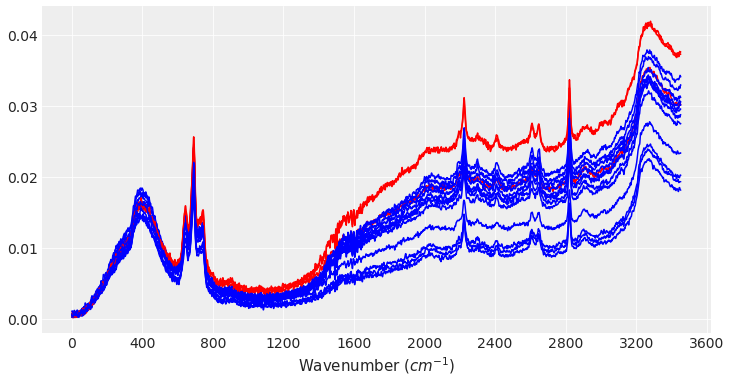

In [4]:
# name of column containing the labels
label_col = data_obj.label_column

# number of non-data columns at right of dataframe
non_data_cols = data_obj.non_data_columns

# list of class labels
class_labels = data_obj.get_class_labels()

# plot dataframe
utl.plot_data(data_obj, 15)

In [5]:
# number of samples from each class
data[label_col].value_counts()

1    29
2    16
Name: label, dtype: int64

In [6]:
# store the data values for all different classes
df = [data.query("label ==  @class_labels[@i]") for i in range(len(class_labels))]

x_n = data.columns[:non_data_cols]
x_s = [df[i][x_n].values for i in range(len(df))]

# Model definition

The following model is assumed:

\begin{equation}
\mu_{m} \sim \text{LogNormal}(0, 1) \\
\sigma_{ab} \sim \Gamma(1, 1) \\
\sigma_{m} \sim |\mathcal{N}(0, \sigma^{2}_{ab})| \\
\mu \sim \mathcal{N}(\mu_{m},\sigma^{2}_{m}) \\
\sigma_{\sigma} \sim \Gamma(1, 1) \\
\sigma \sim |\mathcal{N}(0, \sigma^{2}_{\sigma})| \\
X_{a,b} \sim \mathcal{N}(\mu,\sigma^{2})
\end{equation}

In [7]:
# load model and run inference
nsamples = 16
genmod = mdl.generative_model(x_s, len(class_labels), len(x_n), nsamples=nsamples)

with genmod:
    trace_gm = pm.sample(2000, init='adapt_diag', tune=1000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, sigma_s, mu, sigma_mu, sigma_ab, mu_m]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [06:12<00:00, 16.11draws/s] 


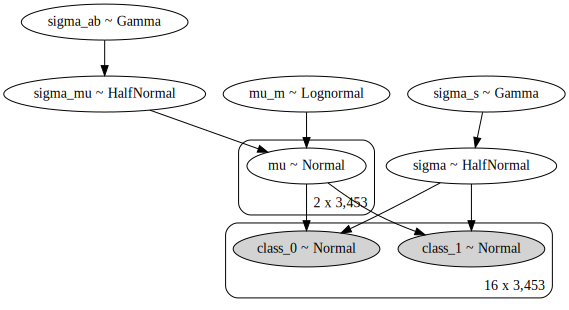

In [8]:
pm.model_to_graphviz(genmod)

In [9]:
az.summary(trace_gm)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"mu[0,0]",0.001,0.001,-0.002,0.003,0.000,0.000,8064.0,1922.0,8070.0,2328.0,1.0
"mu[0,1]",0.001,0.001,-0.002,0.003,0.000,0.000,10570.0,2094.0,10580.0,2708.0,1.0
"mu[0,2]",0.001,0.001,-0.002,0.003,0.000,0.000,10500.0,2313.0,10443.0,2662.0,1.0
"mu[0,3]",0.001,0.001,-0.002,0.003,0.000,0.000,9221.0,1951.0,9242.0,2274.0,1.0
"mu[0,4]",0.001,0.001,-0.002,0.003,0.000,0.000,11027.0,2166.0,11062.0,2555.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
mu_m,0.014,0.000,0.014,0.014,0.000,0.000,6624.0,6624.0,6642.0,2863.0,1.0
sigma_ab,0.226,0.391,0.003,0.902,0.006,0.005,3875.0,3331.0,7165.0,3284.0,1.0
sigma_mu,0.008,0.000,0.008,0.008,0.000,0.000,8936.0,8936.0,8891.0,2908.0,1.0
sigma_s,0.206,0.404,0.002,0.851,0.008,0.006,2618.0,2170.0,6556.0,2745.0,1.0


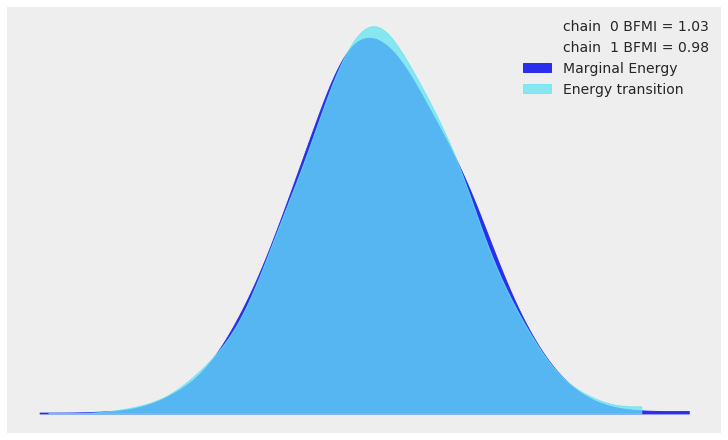

In [10]:
az.plot_energy(trace_gm, figsize=(10, 6));

In [11]:
ppc = pm.sample_posterior_predictive(trace_gm, samples=250, model=genmod)

/home/johan/VirtualEnv/ppsda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 250/250 [00:02<00:00, 101.28it/s]


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


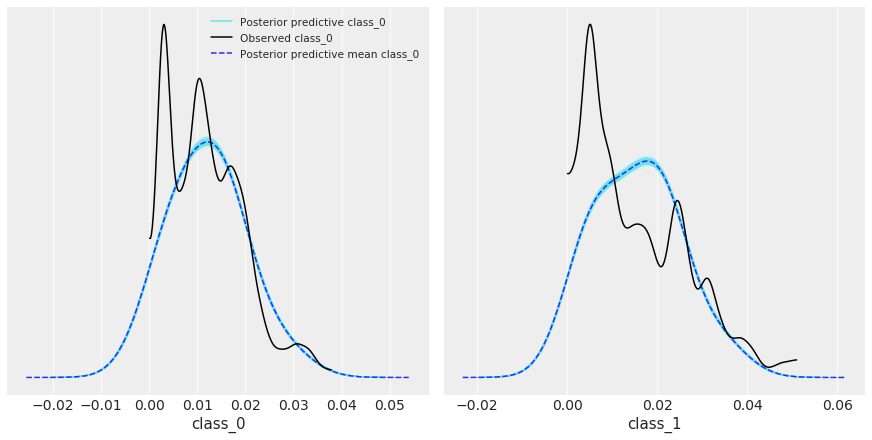

In [12]:
data_ppc = az.from_pymc3(trace=trace_gm, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

In [13]:
print(az.r2_score(x_s[0][:nsamples], ppc['class_0']))

r2        0.621132
r2_std    0.021192
dtype: float64


In [14]:
print(az.r2_score(x_s[1][:nsamples], ppc['class_1']))

r2        0.731877
r2_std    0.017623
dtype: float64


In [15]:
print(az.bfmi(trace_gm))

[1.02740344 0.97575206]


# Posterior samples vs. mean data

In [16]:
# class samples from the posterior
cl_a = ppc['class_0']
cl_b = ppc['class_1']

ppc_class_lst = [cl_a, cl_b]

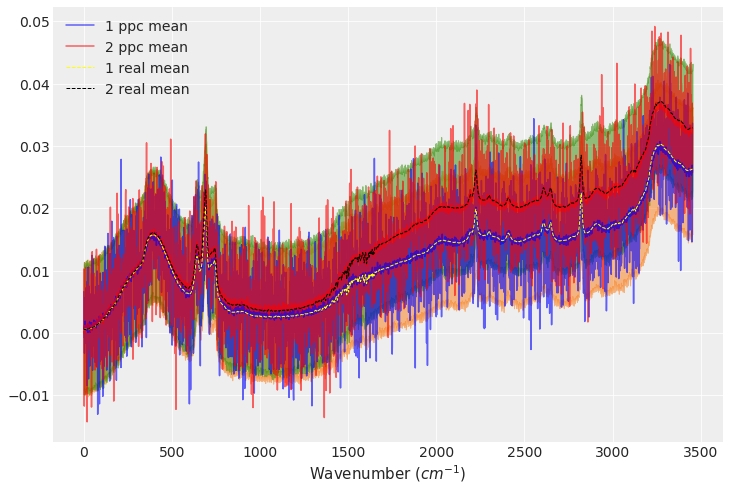

In [17]:
utl.plot_mean_vs_ppc(data_obj, ppc_class_lst)

# Real spectrum vs. posterior samples

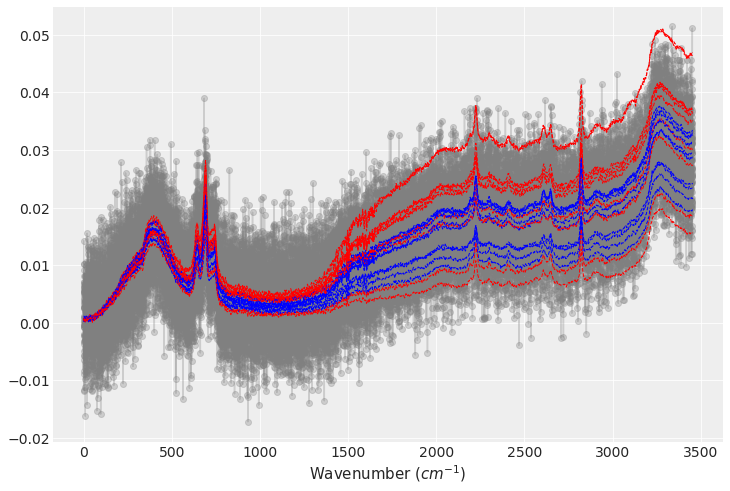

In [18]:
utl.plot_real_vs_ppc(data_obj, ppc_class_lst, 10)

# Save posterior samples to .csv file

In [19]:
utl.save_traces(data_obj, './ppc_samples_beers_raman.csv', 100, ppc_class_lst)